# **Initial Imports**

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [6]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)

from os.path import exists

from IPython.display import clear_output
from google.colab import output


In [47]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/mnist_pytorch_folder/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [106]:
!pip install scikit-plot
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

# **Downloading Dataset and creating Data_loaders**

In [13]:
train_set=torchvision.datasets.MNIST( transform=transforms.Compose([transforms.ToTensor()]),
                                     download=True,
                                     root='.data/MNIST',)

In [96]:
train_set1=torchvision.datasets.MNIST( transform=transforms.Compose([transforms.ToTensor()]),
                                     download=True,
                                     root='.data/MNIST',)
## this dataset is used later to get accuracy on trained dataset

In [14]:
print(train_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [16]:
sample=next(iter(train_set))
print(len(sample))
print(type(sample))
image=sample[0]
label=sample[1]
print(image.shape)
print(type(image))
print(type(label))

2
<class 'tuple'>
torch.Size([1, 28, 28])
<class 'torch.Tensor'>
<class 'int'>


In [17]:
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])


In [18]:
print(train_set)
print(val_set)

In [19]:
train_loader=torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
val_loader=torch.utils.data.DataLoader(val_set,batch_size=100)


In [31]:
batch=next(iter(train_loader))
print(len(batch))
print(type(batch))
images,labels=batch
print(images.shape)
print(labels.shape)

2
<class 'list'>
torch.Size([100, 1, 28, 28])
torch.Size([100])


In [20]:
print(train_loader)
print(val_loader)

# **Creating Model Architecture**

In [32]:
class ModelArchi(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.conv2=nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.lin1=nn.Linear(in_features=192,out_features=120)
    self.lin2=nn.Linear(in_features=120,out_features=60)
    self.final=nn.Linear(in_features=60,out_features=10)

  def forward(self,t):
    t=self.conv1(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)
    t=self.conv2(t)
    t=F.relu(t)
    t=F.max_pool2d(t,kernel_size=2,stride=2)
    t=t.reshape(-1,12*4*4)
    t=self.lin1(t)
    t=F.relu(t)
    t=self.lin2(t)
    t=F.relu(t)
    t=self.final(t)
    return t


In [42]:
def get_number_correct(prediction,labels):
  return prediction.to('cuda').argmax(dim=1).eq(labels.to('cuda')).sum().item()

In [33]:
model1=ModelArchi()
print(model1)

ModelArchi(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (lin1): Linear(in_features=192, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=60, bias=True)
  (final): Linear(in_features=60, out_features=10, bias=True)
)


In [34]:
print("Model1 state_dict") #state_dict is dictionary that maps each layer to its parameter tensor(only layers with learnable parameters and registered buffers[batchnorm mean])
for m in model1.state_dict():
  print(m,'\t',model1.state_dict()[m].size())

Model1 state_dict
conv1.weight 	 torch.Size([6, 1, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([12, 6, 5, 5])
conv2.bias 	 torch.Size([12])
lin1.weight 	 torch.Size([120, 192])
lin1.bias 	 torch.Size([120])
lin2.weight 	 torch.Size([60, 120])
lin2.bias 	 torch.Size([60])
final.weight 	 torch.Size([10, 60])
final.bias 	 torch.Size([10])


# **Training**

In [35]:
class runbuilder():
  @staticmethod
  def get_runs(params):
    runn=[]
    Run=namedtuple('Run',params.keys())
    for v in product(*params.values()):
      runn.append(Run(*v))
    return runn


In [46]:
params=OrderedDict(
    lr=[0.03,0.01,0.006,0.003],

)
evaluater=[]
for runs in runbuilder.get_runs(params):
  model=ModelArchi().to('cuda')
  optimizer=optim.Adam(model.parameters(),lr=runs.lr)
  
  for epoch in range(5):
    total_train_loss_epoch=0
    total_val_loss_epoch=0
    total_correct_epoch=0
    train_loader=torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
    val_loader=torch.utils.data.DataLoader(val_set,batch_size=100)

    #print(train_loader)
    #print(val_loader)
    for batch in train_loader:
      model.train()
      tensor_image_batch=batch[0].to('cuda')
      tensor_label=batch[1].to('cuda')
      pred_batch=model(tensor_image_batch) ##output prediction tensor after forward propagation
      loss=F.cross_entropy(pred_batch,tensor_label) #loss is calculated w.r.t. to true labels
      optimizer.zero_grad() #it zeroes out the previous stored values of gradients
      loss.backward() #calculates the gradients of loss w.r.t layers of network throught  through stored calculations graph
      optimizer.step() #decreases the parameters of the layers the network using adam optimizer and calculated gradients

      total_train_loss_epoch+=loss.item()*train_loader.batch_size

    for batch in val_loader:
       model.eval()
       with torch.no_grad():

         tensor_image_batch=batch[0].to('cuda')
         tensor_label=batch[1].to('cuda')
         preds_batch=model(tensor_image_batch)
         val_loss=F.cross_entropy(preds_batch,tensor_label)

         total_val_loss_epoch+=val_loss.item()*val_loader.batch_size
         total_correct_epoch+=get_number_correct(preds_batch,tensor_label)

    total_train_loss_epoch/=len(train_loader)
    total_val_loss_epoch/=len(val_loader)
    evaluater.append([runs.lr,epoch,total_train_loss_epoch,total_val_loss_epoch,total_correct_epoch,total_correct_epoch/len(val_loader)])
    #print('epoch:',epoch," train_loss: ",total_train_loss_epoch," validation_loss: ",total_val_loss_epoch)


df=pd.DataFrame(evaluater,columns=['Learning_rate','Epoch','Training_loss','Validation_loss','Correct_predictions','Validation_Accuracy'])
df


## this loop is ran to get the best learning rate, which as seen from below dataframe is 0.03(as it has least validation_loss )

,Learning_rate,Epoch,Training_loss,Validation_loss,Correct_predictions,Validation_Accuracy
0,0.030,0,74.665837,33.967834,8941,89.41
1,0.030,1,32.995027,34.972529,8945,89.45
2,0.030,2,30.635415,30.561837,9105,91.05
3,0.030,3,29.252454,31.075842,9077,90.77
4,0.030,4,29.546107,37.619791,8917,89.17
5,0.010,0,21.491127,10.684392,9667,96.67
6,0.010,1,8.519136,9.395359,9729,97.29
7,0.010,2,7.425323,7.736624,9792,97.92
8,0.010,3,6.563096,7.572596,9787,97.87
9,0.010,4,7.151555,7.541704,9826,98.26


In [49]:
model=ModelArchi().to('cuda')
evaluater=[]
optimizer=optim.Adam(model.parameters(),lr=0.003)
for epoch in range(10): ## After knowing the best learning rate,this loop is used to train the model

    total_train_loss_epoch=0
    total_correct_epoch=0
    train_loader=torch.utils.data.DataLoader(train_set,batch_size=100,shuffle=True)
    #val_loader=torch.utils.data.DataLoader(val_set,batch_size=100)

    #print(train_loader)
    #print(val_loader)
    for batch in train_loader:
      model.train()
      tensor_image_batch=batch[0].to('cuda')
      tensor_label=batch[1].to('cuda')
      pred_batch=model(tensor_image_batch)
      loss=F.cross_entropy(pred_batch,tensor_label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_train_loss_epoch+=loss.item()*train_loader.batch_size

    total_train_loss_epoch/=len(train_loader)  
    evaluater.append([epoch,total_train_loss_epoch])

df=pd.DataFrame(evaluater,columns=['Epoch','Training_loss'])

model_save_name='mnist_model.pt'
path=F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(),path)
df







,Epoch,Training_loss
0,0,29.387626
1,1,8.614904
2,2,6.292410
3,3,4.772755
4,4,4.240674
5,5,3.539188
6,6,3.253139
7,7,3.088693
8,8,2.399933
9,9,2.443002


# **Confusion_Matrix**

**getting predictions**

In [97]:
def get_all_preds(network,loader):
  all_preds=torch.tensor([]).to('cuda')
 
  for batch in loader:
    images1=batch[0].to('cuda')
    labels1=batch[1].to('cuda')
    
    preds=network(images1)
    all_preds=torch.cat((all_preds,preds),dim=0)
    
  return all_preds



In [98]:
prediction_loader=torch.utils.data.DataLoader(train_set1,batch_size=1000)

train_preds=get_all_preds(model,prediction_loader)


In [99]:
preds_correct=get_number_correct(train_preds,train_set1.targets)

In [101]:
print('total correct:',preds_correct)
print('accuracy:',preds_correct/len(train_set1.targets))

total correct: 59551
accuracy: 0.9925166666666667


 **CONFUSION MATRIX**

In [102]:
stacked=torch.stack((train_set1.targets,train_preds.to('cpu').argmax(dim=1)),dim=1)

In [104]:
cmt=torch.zeros(10,10,dtype=torch.int32)

In [105]:
for p in stacked:
  true,predicted=p.tolist()
  cmt[true,predicted]=cmt[true,predicted]+1
cmt

tensor([[5900,    0,    1,    0,    0,    1,   16,    0,    5,    0],
        [   1, 6732,    1,    1,    0,    0,    1,    5,    1,    0],
        [   3,   12, 5871,   23,    6,    0,    0,   20,   18,    5],
        [   2,    2,    3, 6077,    0,   15,    0,    2,   18,   12],
        [   0,    8,    0,    0, 5804,    2,    3,    2,    2,   21],
        [   2,    2,    0,    5,    0, 5371,   20,    0,   18,    3],
        [   4,    2,    1,    1,    1,   12, 5887,    0,   10,    0],
        [   2,   23,    3,   18,    2,    4,    0, 6200,    4,    9],
        [   1,    5,    3,    1,    0,    5,    2,    0, 5829,    5],
        [  10,    5,    0,    0,   32,    3,    0,    9,   10, 5880]], dtype=torch.int32)

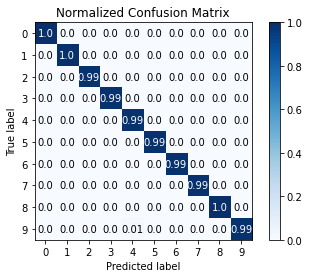

In [108]:
skplt.metrics.plot_confusion_matrix(train_set1.targets,train_preds.to('cpu').detach().numpy().argmax(1), normalize=True)

# **MAKING PREDICTIONS ON TEST SET**

In [110]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=1)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [112]:
correct = 0
total = 0
model=model.to('cpu')
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %
